In [26]:
import pulp
import pandas as pd
import matplotlib.pyplot as plt
from pulp import *
import plotly.express as px
import pandas as pd
import numpy as np

In [27]:
def my_process_dataframe_timeline(args):
    """
    Massage input for bar traces for px.timeline()
    """
    print("my method")
    args["is_timeline"] = True
    if args["x_start"] is None or args["x_end"] is None:
        raise ValueError("Both x_start and x_end are required")

    x_start = args["data_frame"][args["x_start"]]
    x_end = args["data_frame"][args["x_end"]]

    # note that we are not adding any columns to the data frame here, so no risk of overwrite
    args["data_frame"][args["x_end"]] = (x_end - x_start)
    args["x"] = args["x_end"]
    del args["x_end"]
    args["base"] = args["x_start"]
    del args["x_start"]
    return args
px._core.process_dataframe_timeline = my_process_dataframe_timeline

In [28]:
import plotly.io as pio
pio.renderers.default='notebook'

### 1. MODA

#### Objective：  

minimize energy: $$Min: c_{max} $$
minimize penalty: $$Min: TEC $$


In [38]:
def op_original(obj,ep_yes,ep):
    
    new_v_list = [1,1,1]
    new_lam_list = [1,1,1]
    new_o_list = [0,0,0]    
    M = 3 # machine_num
    N = 6 # job_num

    p_dict = {}

    p_dict[(1,0)], p_dict[(1,1)], p_dict[(1,2)], p_dict[(1,3)], p_dict[(1,4)], p_dict[(1,5)], p_dict[(1,6)] =  0,3,6,4,7,8,2
    p_dict[(2,0)], p_dict[(2,1)], p_dict[(2,2)], p_dict[(2,3)], p_dict[(2,4)], p_dict[(2,5)], p_dict[(2,6)] =  0,5,8,4,5,2,2
    p_dict[(3,0)], p_dict[(3,1)], p_dict[(3,2)], p_dict[(3,3)], p_dict[(3,4)], p_dict[(3,5)], p_dict[(3,6)] =  0,7,8,4,4,3,2

    pi_dict = {}
    pi_dict[1], pi_dict[2], pi_dict[3] = 6,8,10

    v_dict = {}
    lam_dict = {}
    v_dict[1], v_dict[2], v_dict[3] = new_v_list[0],new_v_list[1],new_v_list[2]
    lam_dict[1], lam_dict[2], lam_dict[3] = new_lam_list[0],new_lam_list[1],new_lam_list[2]
    B = 10**6
    time_list = []

    for i in range(3):
        time_list.append(new_o_list[i])

    x_dict = {}
    for i in range(M+1):
        for j in range(N+1):
            for k in range(N+1):
                        x_dict[(i,j,k)] = LpVariable("x"+str((i,j,k)),lowBound=0, upBound=1,cat="Binary")
    c_dict = {}
    for j in range(N+1):
        c_dict[(j)] = LpVariable("c"+str(j),lowBound=0,cat="Continuous")                

    o_dict = {}
    for i in range(M+1):
        o_dict[(i)] = LpVariable("o"+str(i),lowBound=0,cat="Continuous")

    c_max = LpVariable("c_max",lowBound=0,cat="Continuous")
    TEC = LpVariable("TEC",lowBound=0,cat="Continuous")

    problem = pulp.LpProblem("Mim energy",LpMinimize)
    if obj == 1:
        problem += c_max 
    elif obj ==2:
        problem += TEC
    if ep_yes == 1:
        problem += TEC <= ep
    for k in range(1,N+1,1):
        con_list = []
        for i in range(1,M+1,1):
            for j in range(N+1):
                    if j != k:
                        con_list.append(x_dict[(i,j,k)])
        problem += lpSum(con_list) == 1

    for j in range(1,N+1,1):
        con_list = []
        for i in range(1,M+1,1):
            for k in range(1,N+1,1):
                    if j != k:
                        con_list.append(x_dict[(i,j,k)])
        problem += lpSum(con_list) <= 1

    for i in range(1,M+1,1):
        con_list = []
        for k in range(1,N+1,1):
                con_list.append(x_dict[(i,0,k)])
        problem += lpSum(con_list) <= 1

    for j in range(1,N+1,1):
        for i in range(1,M+1,1):
            sep_one_list = []
            sep_two_list = []
            for k in range(N+1):
                    if j != k:
                        sep_one_list.append(x_dict[(i,j,k)])
            for h in range(N+1):
                    if j != h:
                        sep_two_list.append(x_dict[(i,h,j)])   
            problem += lpSum(sep_one_list) - lpSum(sep_two_list) == 0

    for i in range(1,M+1,1):
            for j in range(N+1):
                for k in range(1,N+1,+1):
                    if j != k:
                        problem += c_dict[k] - c_dict[j] + B*(1-x_dict[(i,j,k)]) >= (p_dict[(i,k)] / v_dict[i]) 

    problem += c_dict[0] == 0

    ####################################################################################
    ## new_o
    for i in range(1,M+1,1):
        con_list = []
        for j in range(N+1):
            for k in range(1,N+1,1):
                    if j != k:
                        con_list.append([ (p_dict[(i,k)]/v_dict[i]) * x_dict[(i,j,k)] ])
        problem += lpSum(con_list) + time_list[i-1] == o_dict[i]
    ####################################################################################

    for i in range(1,M+1,1):
        problem += c_max >= o_dict[i]

    con_list = []
    for i in range(1,M+1,1):
        for j in range(N+1):
            for k in range(1,N+1,1):
                    if j != k:
                        con_list.append([ (lam_dict[i]*pi_dict[i]*p_dict[(i,k)]/v_dict[i]) * x_dict[(i,j,k)]  ])
    problem += lpSum(con_list) <= TEC


    con_list = []
    for i in range(1,M+1,1):
        for j in range(N+1):
            for k in range(1,N+1,1):
                    if j != k:
                        con_list.append([ (lam_dict[i]*pi_dict[i]*p_dict[(i,k)]/v_dict[i]) * x_dict[(i,j,k)]  ])
    problem += lpSum(con_list) <= TEC

    solution = problem.solve()
    print(value(c_max),value(TEC))


    j_loc = {}
    for v in problem.variables():
        if v.varValue == 1:
            if "new" not in v.name:
                if v.name[-2] != "0":
                    j_loc[int(v.name[-2])] = int(v.name[2])

    m_loc = {}
    for i in range(1,M+1,1):
        pair_loc = {}
        for v in problem.variables():
            if v.varValue == 1:
                if v.name[-2] != "0":
                    if "new" not in v.name:
                        if v.name[2] == str(i):
                            pair_loc[int(v.name[5])] = int(v.name[-2])
        sort_job = []
        sep = 0
        while (len(sort_job) < len(pair_loc)):
            for key, val in pair_loc.items():
                if key == sep:
                    sep = val
                    sort_job.append(val)
        m_loc[i] = sort_job



    c_loc = []
    for v in problem.variables():
        if "c" in v.name:
            if v.name == "c0" or v.name == "c_max":
                continue
            c_loc.append(v.varValue)

    j_m = []
    for i in range(1,N+1,1):
        j_m.append(str(j_loc[i]))
    job_name = []
    for i in range(1,N+1,1):
        job_name.append("JOB"+str(i))
    start_loc = {}
    for key, v in m_loc.items():
        for j in v:
            if v.index(j) == 0:
                start_loc[j] = 0
            else:
                start_loc[j] = c_loc[sep-1]
            sep = j       
    start_list = []
    for i in range(1,N+1,1):
        start_list.append(start_loc[i])

    for i in range(1,4,1):
        job_name.append("OLD_JOB")
        start_list.append(0)
        c_loc.append(new_o_list[i-1])
        j_m.append(str(i))

    df = pd.DataFrame()
    df["Task"] = job_name
    df["Start"] = start_list
    df["Finish"] = c_loc
    df["Machine"] = j_m
    df['delta'] = df['Finish'] - df['Start']

    for i in range(1,M+1,1): 
        df.loc[df["Machine"]==str(i) ,["Start","Finish"]] = df.loc[df["Machine"]==str(i),["Start","Finish"]] +new_o_list[i-1]

    for i in range(1,M+1,1): 
        df.loc[N+i-1,["Start","Finish"]] = df.loc[N+i-1,["Start","Finish"]] - new_o_list[i-1] 

    fig = px.timeline(df, x_start="Start", x_end="Finish", y="Machine", color="Task",text="Task")
    fig.update_yaxes(autorange="reversed") 

    fig.layout.xaxis.type = 'linear'
    fig.data[0].x = df.delta.tolist() 
    fig.show()
    return [value(TEC),value(c_max)]

In [39]:
op_original(1,0,0)

8.0 184.0
my method


[184.0, 8.0]

In [40]:
op_original(2,0,0)

15.0 146.0
my method


[146.0, 15.0]

### epision method

### range 146~184

In [41]:
c_max_list = []
TEC_list = []
for i in list(range(146,184+2,2)):
    c_max_list.append(op_original(1,1,i)[0])
    TEC_list.append(op_original(1,1,i)[1])

15.0 146.0
my method


D:\anaconda\lib\site-packages\pulp\pulp.py:1199: UserWarning:

Spaces are not permitted in the name. Converted to '_'



15.0 146.0
my method


15.0 146.0
my method


15.0 146.0
my method


13.0 150.0
my method


13.0 150.0
my method


13.0 150.0
my method


13.0 150.0
my method


11.0 154.0
my method


11.0 154.0
my method


11.0 154.0
my method


11.0 154.0
my method


9.0 158.0
my method


9.0 158.0
my method


9.0 158.0
my method


9.0 158.0
my method


9.0 158.0
my method


9.0 158.0
my method


9.0 162.0
my method


9.0 162.0
my method


9.0 166.0
my method


9.0 166.0
my method


9.0 158.0
my method


9.0 158.0
my method


9.0 158.0
my method


9.0 158.0
my method


9.0 158.0
my method


9.0 158.0
my method


9.0 162.0
my method


9.0 162.0
my method


9.0 158.0
my method


9.0 158.0
my method


9.0 162.0
my method


9.0 162.0
my method


9.0 162.0
my method


9.0 162.0
my method


9.0 162.0
my method


9.0 162.0
my method


8.0 184.0
my method


8.0 184.0
my method


In [42]:
ep_df = pd.DataFrame()
ep_df["c_max"] = c_max_list
ep_df["TEC"] = TEC_list

In [43]:
ep_df

,c_max,TEC
0,146.0,15.0
1,146.0,15.0
2,150.0,13.0
3,150.0,13.0
4,154.0,11.0
5,154.0,11.0
6,158.0,9.0
7,158.0,9.0
8,158.0,9.0
9,162.0,9.0


Text(0, 0.5, 'TEC')

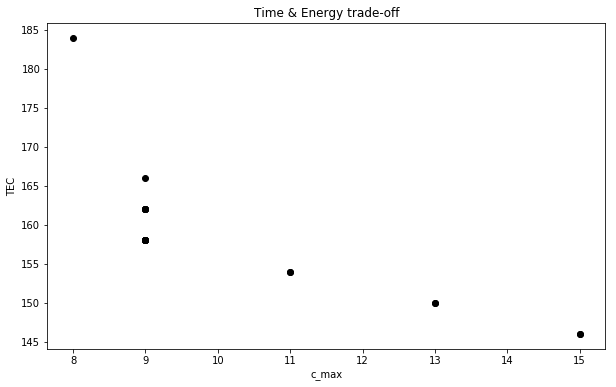

In [47]:
plt.figure(figsize=(10,6))
plt.title("Time & Energy trade-off")
plt.scatter(ep_df["TEC"],ep_df["c_max"],label="epision",color="black")
plt.xlabel("c_max")
plt.ylabel("TEC")